In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
from pprint import pprint 

from optiland import optic
from optiland.materials import Material
from optiland.materials.ideal import IdealMaterial
from optiland.apodization import GaussianApodization
from optiland.analysis.irradiance import IncoherentIrradiance
from optiland.analysis.intensity import RadiantIntensity
from optiland.physical_apertures import RadialAperture, RectangularAperture
import optiland.backend as be
from optiland.distribution import GaussianDistribution

from classes.cartesian_oval import CartesianOvalCollimator
from classes.gaussian_beam import GaussianBeam
from classes.beam_shaper import BeamShaper

be.set_backend("torch")
be.set_precision("float32")
be.grad_mode.enable()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Optiland backend successfully set to: {be.get_backend()}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"PyTorch precision set to: {torch.get_default_dtype()}")

Optiland backend successfully set to: torch
PyTorch version: 2.10.0+cu126
CUDA available: True
PyTorch precision set to: torch.float32


In [2]:
# Gaussian Source Parameters
wavelength = np.array([1.55]) # in micrometers
omega_0 = np.array([5.2]) # in micrometers

In [3]:
H_LAF3B = Material(name="H-LAF3B")
print(H_LAF3B.n(wavelength[0]))

index1 = H_LAF3B.n(wavelength = wavelength[0])
index1_float = float(index1)

H_LAF3B_ideal= IdealMaterial(n=index1_float)

tensor([1.7185], grad_fn=<SqrtBackward0>)


C:\Users\shown\AppData\Local\Temp\ipykernel_6896\3943658531.py:5: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  index1_float = float(index1)


In [4]:
source = GaussianBeam(
    wavelength=float(wavelength[0]),
    omega_0=float(omega_0[0]),
)

beam_size = source.beam_radius(z=30) # in millimeters at z = 30 mm

semi_dia = be.ceil(beam_size)

# Glass: CDGM H-LAF3B
collimator = CartesianOvalCollimator(
    z_0=30, # in millimeters
    n = index1_float, # refractive index of the collimator material
    r_max=float(semi_dia), # in millimeters    
)

approx_ea = collimator.paraxial_fit()
fitted_ea = collimator.even_aspheric_fitting(approx_ea)


In [5]:
print("Source Information:")
print(f"omega(z=30mm): {beam_size} millimeters")
print("Rayleigh Range: {:.4f} um".format(source.rayleigh_range))
print("Divergence Angle (half-angle): {:.4f} urad".format(source.div_angle * 1e3))
print("Divergence Angle (half-angle): {:.4f} degrees".format(np.degrees(source.div_angle)))
print("Divergence Angle at z = 30 mm: {:.4f} degrees".format(np.degrees(source.div_angle_z(z=30))))
print("object NA=", np.sin(source.div_angle))


Source Information:
omega(z=30mm): 2.846429693572783 millimeters
Rayleigh Range: 54.8056 um
Divergence Angle (half-angle): 94.8808 urad
Divergence Angle (half-angle): 5.4363 degrees
Divergence Angle at z = 30 mm: 5.4201 degrees
object NA= 0.09473853676366122


In [6]:
print("Collimator Surface Information:")
print(f"Collimator semi-diameter: {collimator.r_max} millimeters")
print("\n")
print(f"Paraxial fit radius: {approx_ea.vertex_r} millimeters")
print(f"Paraxial fit conic constant: {approx_ea.k}")
print("\n")
print(f"Fitted even aspheric radius: {fitted_ea.vertex_r} millimeters")
print(f"Fitted even aspheric conic constant: {fitted_ea.k}")

Collimator Surface Information:
Collimator semi-diameter: 3.0 millimeters


Paraxial fit radius: 21.556352376937866 millimeters
Paraxial fit conic constant: -2.9533971893499853


Fitted even aspheric radius: 21.556352376937866 millimeters
Fitted even aspheric conic constant: -2.9533971893499853


In [7]:
emitter = optic.Optic()

# Set System Data
emitter.set_aperture(aperture_type="objectNA", value=np.sin(source.div_angle)) # "EPD", "imageFNO"

emitter.set_field_type(field_type = "angle") # "object_height"; "paraxial_image_height"; "real_image_height"; "angle"
emitter.add_field(y=0)

emitter.add_wavelength(value=float(wavelength[0]), is_primary=True)

sigma_apo = 1/np.sqrt(2) # apodization factor G = 1. I = exp(-(Px^2 + Py^2) / (2 * self.sigma^2)) => sigma = 1/sqrt(2G) where apodization factor G = 1 in this case 

gaussian_apo = GaussianApodization(sigma=sigma_apo)
emitter.set_apodization(gaussian_apo)

# Set Lens Data
detector_aperture1 = RectangularAperture(
    x_min = -semi_dia,
    x_max = semi_dia,
    y_min = -semi_dia,
    y_max = semi_dia,
)

radial_aperture1 = RadialAperture(r_max=semi_dia)
radial_aperture2 = RadialAperture(r_max=16)

detector_aperture2 = RectangularAperture(
    x_min = -16,
    x_max = 16,
    y_min = -16,
    y_max = 16,
)


# Point source
emitter.add_surface(index=0, radius=np.inf, thickness=collimator.z_0, comment="Point Source")

# detector surface 1
emitter.add_surface(index=1, radius=np.inf, thickness=0, comment="Dummy surface", aperture=detector_aperture1)

# Collimator surface
emitter.add_surface(index=2, thickness=4, is_stop=True, radius=approx_ea.vertex_r, conic=approx_ea.k, material=H_LAF3B_ideal, comment="Collimator surface", aperture=radial_aperture1)

### Calculate beam shaper parameters
beam_shaper = BeamShaper(omega=beam_size,
                         r_max=beam_size,
                         R_max=10,
                         d=20,
                         n=float(index1),
                         type="Galilean",
                         approx=True,
)
pprint(beam_shaper.result)
###

# Beam shaper surface 1
emitter.add_surface(index=3, radius=float(beam_shaper.r_c1), thickness=20, conic=float(beam_shaper.k_1), comment="Beam shaper surface 1", aperture=radial_aperture1)

# Beam shaper surface 2
emitter.add_surface(index=4, radius=float(beam_shaper.r_c2), thickness=7, conic=float(beam_shaper.k_2), material=H_LAF3B_ideal, comment="Beam shaper surface 2", aperture=radial_aperture2)

emitter.add_surface(index=5, radius=np.inf, thickness=50, comment="Beam shaper exit", aperture = radial_aperture2)

# Image plane, crucial for right lens.draw()
emitter.add_surface(index=6, radius=np.inf, thickness=0, comment="Image plane", aperture=detector_aperture2)

emitter.update_paraxial()

{'k_1': -4.921317948948574,
 'k_2': -3.321710097224296,
 'r_c1': 3.3089288388421876,
 'r_c2': 17.679830423467433}


In [8]:
emitter.info()

╒════╤═════════════════╤═══════════════════════╤═══════════╤═════════════╤════════════════════╤══════════╤═════════════════╕
│    │ Type            │ Comment               │    Radius │   Thickness │ Material           │    Conic │   Semi-aperture │
╞════╪═════════════════╪═══════════════════════╪═══════════╪═════════════╪════════════════════╪══════════╪═════════════════╡
│  0 │ Planar          │ Point Source          │ inf       │          30 │ Air                │  0       │          0      │
│  1 │ Planar          │ Dummy surface         │ inf       │           0 │ Air                │  0       │          2.855  │
│  2 │ Stop - Standard │ Collimator surface    │  21.5564  │           4 │ 1.7185450792312622 │ -2.9534  │          3      │
│  3 │ Standard        │ Beam shaper surface 1 │   3.30893 │          20 │ Air                │ -4.92132 │          3      │
│  4 │ Standard        │ Beam shaper surface 2 │  17.6798  │           7 │ 1.7185450792312622 │ -3.32171 │         16      │


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Normalized Pupil Coordinate X', ylabel='Normalized Pupil Coordinate Y'>)

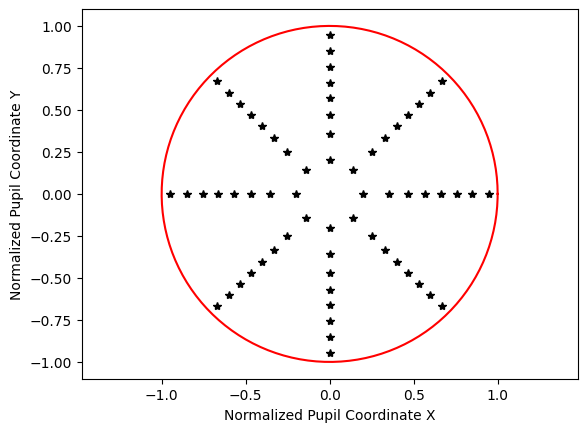

In [10]:
distribution = GaussianDistribution(sigma=sigma_apo)
distribution.generate_points(num_points=50)
distribution.view()

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Z [mm]', ylabel='Y [mm]'>)

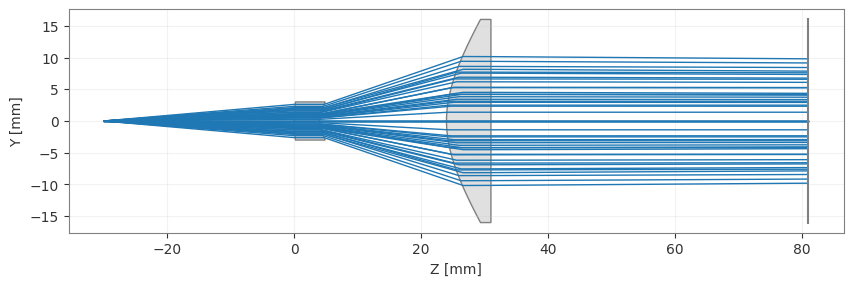

In [14]:
emitter.draw(num_rays=10, distribution=distribution) # "line_x", "line_y", "positive_line_x", "positive_line_y", "random", "uniform", "hexapolar", "cross", "ring"

In [19]:
rays = emitter.trace(Hx=0, Hy=0, wavelength=float(wavelength[0]), num_rays=200, distribution=distribution) 

# Irradiance

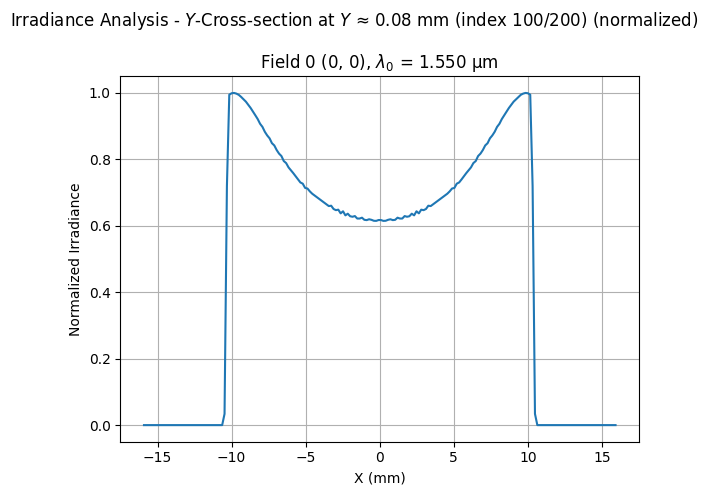

In [13]:
for name in ("x_min", "x_max", "y_min", "y_max"):
    v=getattr(detector_aperture1, name, None)
    if torch.is_tensor(v):
        setattr(detector_aperture1, name, float(v.detach().cpu().item()))

with torch.no_grad():
    img_irr = IncoherentIrradiance(emitter, num_rays = 1000, detector_surface = -1, res = (200, 200), distribution="uniform")
    #img_irr.view(figsize=(8, 6), cmap="magma")
    img_irr.view(cross_section=('cross-y', 100))

╒════╤═══════════════╤══════════════╤══════════╤═════════════╤════════════╤═════════╤═════════════════╕
│    │ Type          │ Comment      │   Radius │   Thickness │ Material   │   Conic │   Semi-aperture │
╞════╪═══════════════╪══════════════╪══════════╪═════════════╪════════════╪═════════╪═════════════════╡
│  0 │ Planar        │ Point Source │      inf │          30 │ Air        │       0 │           0     │
│  1 │ Stop - Planar │ Image        │      inf │         nan │ Air        │       0 │           2.855 │
╘════╧═══════════════╧══════════════╧══════════╧═════════════╧════════════╧═════════╧═════════════════╛



(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Z [mm]', ylabel='Y [mm]'>)

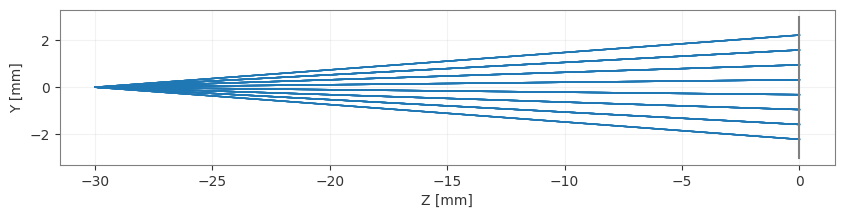

In [30]:
test = optic.Optic()

test.set_aperture(aperture_type="objectNA", value=np.sin(source.div_angle)) # "EPD", "imageFNO"

test.set_field_type(field_type = "angle") # "object_height"; "paraxial_image_height"; "real_image_height"; "angle"
test.add_field(y=0)

test.add_wavelength(value=float(wavelength[0]), is_primary=True)

gaussian_apo = GaussianApodization(sigma=1/np.sqrt(2)) # I = exp(-(Px^2 + Py^2) / (2 * self.sigma^2)) => sigma = 1/sqrt(2G) where apodization factor G = 1 in this case 
test.set_apodization(gaussian_apo)

# Set Lens Data
detector_aperture1 = RectangularAperture(
    x_min = -semi_dia,
    x_max = semi_dia,
    y_min = -semi_dia,
    y_max = semi_dia,
)

test.add_surface(index=0, radius=np.inf, thickness=collimator.z_0, comment="Point Source")

# detector surface 1
test.add_surface(index=1, radius=np.inf, thickness=0, comment="Image", is_stop = True, aperture=detector_aperture1)

test.update_paraxial()
test.info()
test.draw(num_rays=10, distribution="uniform") # "line_x", "line_y", "positive_line_x", "positive_line_y", "random", "uniform", "hexapolar", "cross", "ring"

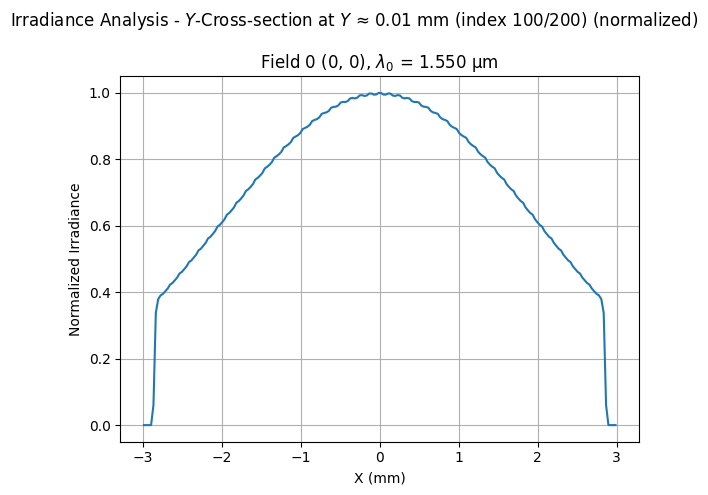

In [32]:
for name in ("x_min", "x_max", "y_min", "y_max"):
    v=getattr(detector_aperture1, name, None)
    if torch.is_tensor(v):
        setattr(detector_aperture1, name, float(v.detach().cpu().item()))
        
with torch.no_grad():
    img_irr = IncoherentIrradiance(test, num_rays = 1000, detector_surface = -1, res = (200, 200), distribution="uniform")
    #img_irr.view(figsize=(8, 6), cmap="magma")
    img_irr.view(cross_section=('cross-y', 100))

# surface.intensity

torch.Size([31064])
torch.Size([31064])
torch.Size([31064])
(31064,)


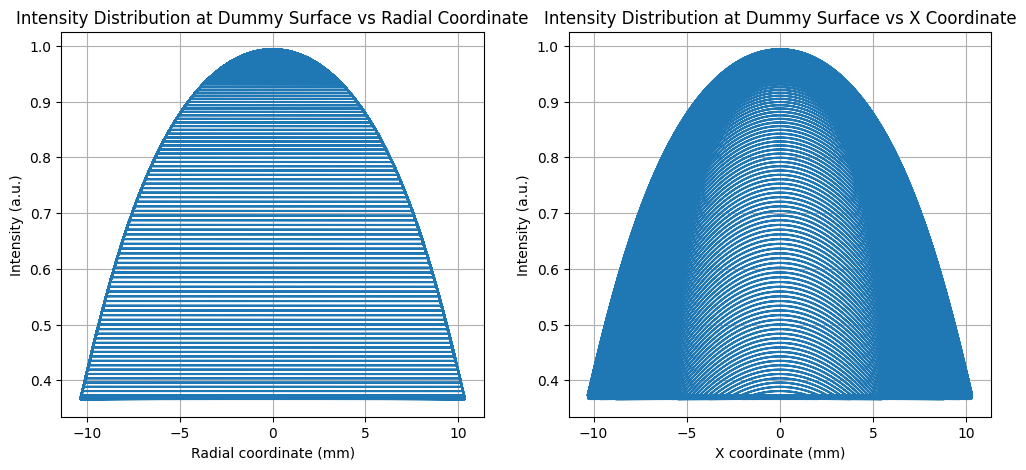

In [47]:
Image_surf = emitter.surface_group.surfaces[-1]
intensity = rays.i

print(intensity.shape)
print(rays.i.shape)
print(Image_surf.x.shape)   

x = Image_surf.x
x = x.detach().cpu().numpy()
y = Image_surf.y
y = y.detach().cpu().numpy()
intensity = intensity.detach().cpu().numpy()   
r = x**2 + y**2
r = np.sign(x) * np.sqrt(r)  

print(r.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(r, intensity)
ax1.set_xlabel("Radial coordinate (mm)")
ax1.set_ylabel("Intensity (a.u.)")
ax1.set_title("Intensity Distribution at Dummy Surface vs Radial Coordinate")
ax1.grid()

ax2.plot(x, intensity)
ax2.set_xlabel("X coordinate (mm)")
ax2.set_ylabel("Intensity (a.u.)")
ax2.set_title("Intensity Distribution at Dummy Surface vs X Coordinate")
ax2.grid()

plt.show()

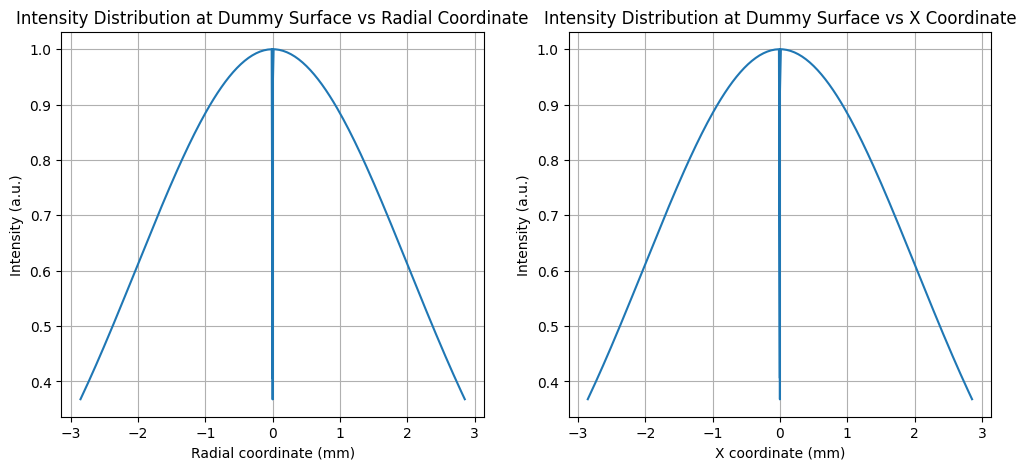

: 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

idx_r = np.argsort(r)
ax1.plot(r[idx_r], intensity[idx_r])
ax1.set_xlabel("Radial coordinate (mm)")
ax1.set_ylabel("Intensity (a.u.)")
ax1.set_title("Intensity Distribution at Dummy Surface vs Radial Coordinate")
ax1.grid()

id_x = np.argsort(x)
ax2.plot(x[id_x], intensity[id_x])
ax2.set_xlabel("X coordinate (mm)")
ax2.set_ylabel("Intensity (a.u.)")
ax2.set_title("Intensity Distribution at Dummy Surface vs X Coordinate")
ax2.grid()

plt.show()

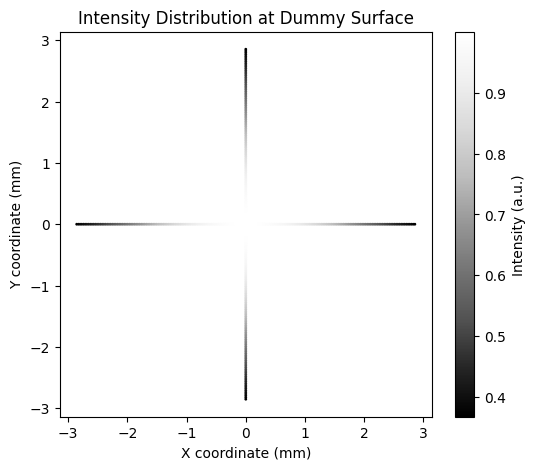

: 

In [ ]:
plt.figure(figsize=(6, 5))
plt.scatter(x, y, c=intensity, s=1, cmap='Greys_r')
plt.xlabel("X coordinate (mm)")
plt.ylabel("Y coordinate (mm)")
plt.title("Intensity Distribution at Dummy Surface")
plt.colorbar(label="Intensity (a.u.)")
plt.show()